In [13]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage
from scipy.ndimage import gaussian_filter
from scipy.interpolate import griddata
from matplotlib.path import Path
from matplotlib.lines import Line2D


In [14]:
x1 = np.load('x_05_1_new85.npy')
y1 = np.load('y_05_1_new85.npy')
z1 = np.load('z_05_1_new85.npy')

x1iso = np.load('x_iso_05_new85.npy')
y1iso = np.load('y_iso_05_new85.npy')

x1iso2 = np.load('x_iso2_05_new85.npy')
y1iso2 = np.load('y_iso2_05_new85.npy')

x1last = np.load('x_last_05_new85.npy')
y1last = np.load('y_last_05_new85.npy')

x2 = np.load('x_05_1_new85.npy')
y2 = np.load('y_05_1_new85.npy')
z2 = np.load('z_05_1_new85.npy')

In [15]:
D = 16.4e6*3.08e18
Mbh = 2e33*6.5e9
G = 6.67e-8
c = 3e10
rg = G*Mbh/c**2

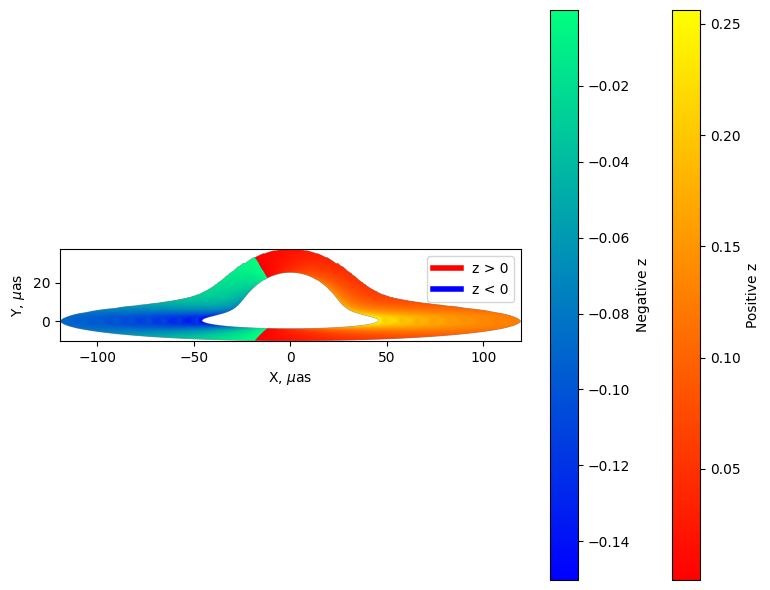

In [16]:
# Closing of isoflow circuits, if necessary
for arr_x, arr_y in [(x1iso, y1iso), (x1iso2, y1iso2), (x1last, y1last)]:
    if (arr_x[0] != arr_x[-1]) or (arr_y[0] != arr_y[-1]):
        arr_x = np.append(arr_x, arr_x[0])
        arr_y = np.append(arr_y, arr_y[0])


scale_factor = 206265 * 1e6 / D
x1, y1, x2, y2 = [arr * scale_factor for arr in [x1, y1, x2, y2]]
x1iso, y1iso = [arr * scale_factor for arr in [x1iso, y1iso]]
x1iso2, y1iso2 = [arr * scale_factor for arr in [x1iso2, y1iso2]]
x1last, y1last = [arr * scale_factor for arr in [x1last, y1last]]

z1, z2 = z1 - 1, z2 - 1

# merging arrays
x = np.concatenate([x1, x2])
y = np.concatenate([y1, y2])
z = np.concatenate([z1, z2])

# setting up grids
grid_x, grid_y = np.mgrid[min(x):max(x):1000j, min(y):max(y):1000j]

# interpolation z
grid_z = griddata((x, y), z, (grid_x, grid_y), method='linear')

grid_z1 = griddata((x1, y1), z1, (grid_x, grid_y), method='linear')
grid_z2 = griddata((x2, y2), z2, (grid_x, grid_y), method='linear')


#for i in range(len(x1last)):
#    x1last[i] = x1last[i]/scale_factor
#    y1last[i] = y1last[i]/scale_factor

# masks
boundary_path = Path(np.column_stack((x1last, y1last)))
inner_boundary = Path(np.column_stack((x1iso, y1iso)))
points = np.column_stack((grid_x.ravel(), grid_y.ravel()))
mask_outside = boundary_path.contains_points(points).reshape(grid_x.shape)
mask_inside = inner_boundary.contains_points(points).reshape(grid_x.shape)
final_mask = mask_outside & ~mask_inside

# separate positive and negative z
grid_z_pos = np.where((final_mask) & (grid_z1 > 0), grid_z1, np.nan)
grid_z_neg = np.where((final_mask) & (grid_z1 <= 0), grid_z1, np.nan)

# plotting figures
fig, axes = plt.subplots(figsize=(8, 6))

# positive z
im_pos = axes.imshow(grid_z_pos.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap='autumn', alpha=1)
fig.colorbar(im_pos, ax=axes, label='Positive z')

# negative z
im_neg = axes.imshow(grid_z_neg.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap='winter', alpha=1)
fig.colorbar(im_neg, ax=axes, label='Negative z')

axes.set_xlabel(r"X, $\mu$as")
axes.set_ylabel(r"Y, $\mu$as")

# adding legend
legend_elements = [Line2D([0], [0], color='red', lw=4, label='z > 0'),
                   Line2D([0], [0], color='blue', lw=4, label='z < 0')]
axes.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.show()